In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt;
import tensorflow as tf
import tensorflow_hub as hub

### Read CSV

In [80]:
custom_color = 'skyblue'
custom_palette = 'viridis'
data = '/kaggle/input/negative-sentiment/negative_sentiment2.csv'
df = pd.read_csv(data)
df.head()

,rating,comment,day,year,month,combined_date,day_of_week,sentiment_score,sentiment,no_stop_words,group,similarity_degree
0,NaN,This is a useless piece of software. Every ti...,22,2023,12,2023-12-22,Monday,-0.3818,Negative,useless piece software . time download accou...,9,1.0
1,NaN,Getting rid of that subscription or even delet...,20,2023,12,2023-12-20,Saturday,-0.4588,Negative,Getting rid subscription deleting account impo...,5,1.0
2,1.0,I've had the Quicker Starter for quite sometim...,12,2023,12,2023-12-12,Friday,-0.7825,Negative,Quicker Starter accountant hates Profit Loss s...,8,1.0
3,4.0,don't use it much. Need a way to not give pass...,1,2023,9,2023-09-01,Monday,-0.6390,Negative,use . Need way password time . Program remem...,8,1.0
4,3.0,It is very very different from QuickBooks. I ...,5,2023,9,2023-09-05,Friday,-0.9027,Negative,different QuickBooks . QuickBooks user 15 ye...,7,1.0


### Use Google NLP Model To Extract Themes From Reviews

In [50]:
# Load Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
tf.random.set_seed(42)

# find representative statements
def get_representative_statements(embeddings, statements, num_representatives=10):
    # Calculate pairwise cosine similarities
    similarities = tf.keras.losses.cosine_similarity(embeddings, embeddings)

    # ndicex of representative statements
    representative_indices = similarities.numpy().argsort()[-num_representatives:][::-1]

    # Get representative statements
    representative_statements = statements.iloc[representative_indices]
    return representative_statements


In [52]:
reviews = df['no_stop_words']

# Calculate embeddings for each review
review_embeddings = embed(reviews)

# Number of representative statements
num_representatives = 10

# Get representative statements
representative_statements = get_representative_statements(review_embeddings, reviews, num_representatives)

representative_statements

1347    Quicken personal finance management past 10 + ...
807         TOOOO expensive , discount long term customer
277     Good Bill Pay Module . Bill pay module rough w...
112     Mac version work stock , especially setting em...
954     system problems . wo download bank accounts co...
808     desktop application slow . likely years data ,...
597     problems data lost program closing spontaneous...
1277    think updated Quicken taxes TurboTax .   want ...
1549    renewed activated new Quicken 03/31 . \n new p...
572     download transactions , Quicken redates relabe...
Name: no_stop_words, dtype: object

In [6]:
rep_statements_df = pd.DataFrame({
    'Representative_Statement': representative_statements.values,
    'Index': representative_statements.index
})
rep_statements_df

,Representative_Statement,Index
0,Quicken personal finance management past 10 + ...,1347
1,"TOOOO expensive , discount long term customer",807
2,Good Bill Pay Module . Bill pay module rough w...,277
3,"Mac version work stock , especially setting em...",112
4,system problems . wo download bank accounts co...,954
5,"desktop application slow . likely years data ,...",808
6,problems data lost program closing spontaneous...,597
7,think updated Quicken taxes TurboTax . want ...,1277
8,renewed activated new Quicken 03/31 . \n new p...,1549
9,"download transactions , Quicken redates relabe...",572


### Assign Groups Based on Which Representative Statement A Review Most Resembles

In [8]:
representative_embeddings = embed(rep_statements_df['Representative_Statement'])

# Normalize embeddings
review_embeddings = tf.linalg.l2_normalize(review_embeddings, axis=1)
representative_embeddings = tf.linalg.l2_normalize(representative_embeddings, axis=1)

# Calculate cosine similarities using matmul
similarities = tf.matmul(review_embeddings, tf.transpose(representative_embeddings))

# Assign the group (representative statement index) with the highest similarity
df['group'] = np.argmax(similarities.numpy(), axis=1)

# Display the DataFrame with the 'group' column
df[['comment', 'group']].head()

,comment,group
0,This is a useless piece of software. Every ti...,9
1,Getting rid of that subscription or even delet...,5
2,I've had the Quicker Starter for quite sometim...,8
3,don't use it much. Need a way to not give pass...,8
4,It is very very different from QuickBooks. I ...,7


In [9]:
df['group'].value_counts().sort_values(ascending=False)

group
4    340
7    313
0    284
8    244
2    140
6    136
5     75
9     68
1     42
3     23
Name: count, dtype: int64

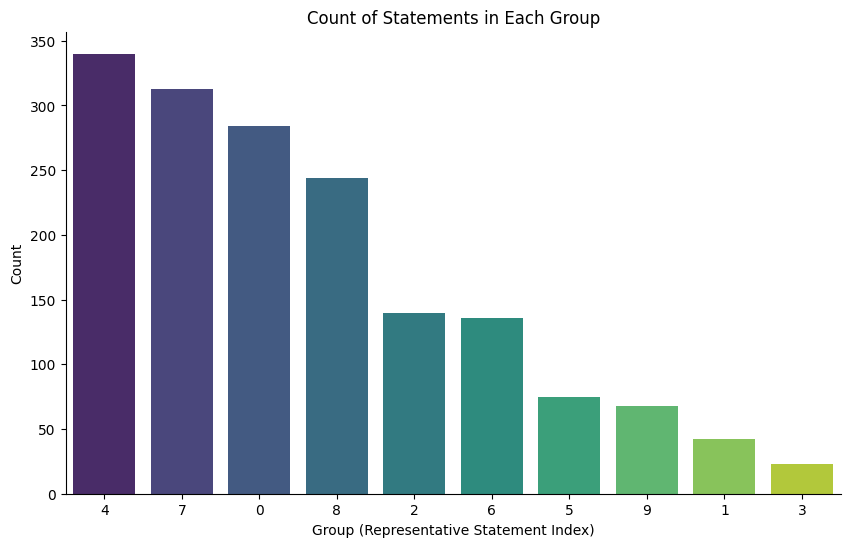

In [81]:
import seaborn as sns;
group_counts = df['group'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='group', order=group_counts.index, palette= custom_pallete)
plt.title('Count of Statements in Each Group')
plt.xlabel('Group (Representative Statement Index)')
plt.ylabel('Count')

ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [11]:
group_counts = df['group'].value_counts()

# Calculate percentages
group_percentages = (group_counts / group_counts.sum()) * 100
rounded_percentages = round(group_percentages, 2)

# Calculate cumulative percentages
cumulative_percentages = rounded_percentages.cumsum()
group_percentages_df = pd.DataFrame({
    'group': rounded_percentages.index,
    'percentage': rounded_percentages.values,
    'cumulative_percentage': cumulative_percentages.values
})

group_percentages_df

,group,percentage,cumulative_percentage
0,4,20.42,20.42
1,7,18.80,39.22
2,0,17.06,56.28
3,8,14.65,70.93
4,2,8.41,79.34
5,6,8.17,87.51
6,5,4.50,92.01
7,9,4.08,96.09
8,1,2.52,98.61
9,3,1.38,99.99


In [12]:
group_percentages_df['Index'] = group_percentages_df[group_percentages_df['group'].isin(rep_statements_df.index)]['group'].map(rep_statements_df['Index'])
group_percentages_df

,group,percentage,cumulative_percentage,Index
0,4,20.42,20.42,954
1,7,18.80,39.22,1277
2,0,17.06,56.28,1347
3,8,14.65,70.93,1549
4,2,8.41,79.34,277
5,6,8.17,87.51,597
6,5,4.50,92.01,808
7,9,4.08,96.09,572
8,1,2.52,98.61,807
9,3,1.38,99.99,112


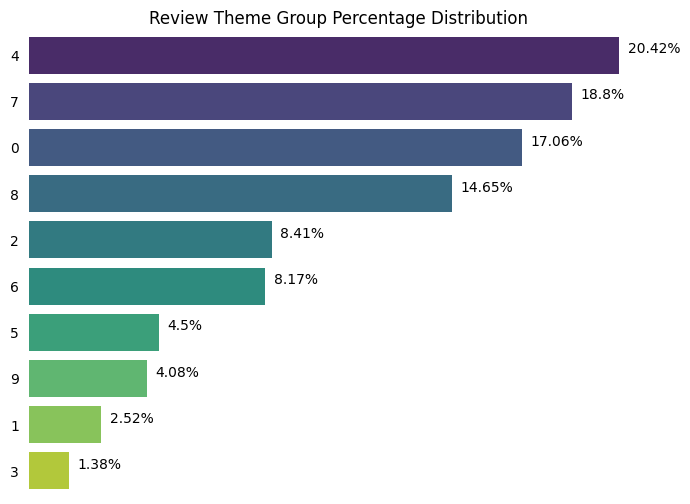

In [82]:
group_percentages_df_sorted = group_percentages_df.sort_values(by='percentage', ascending=False)

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=group_percentages_df_sorted, x='percentage', y='group', orient='h',
                 order=group_percentages_df_sorted['group'], palette= custom_pallete)

plt.title('Review Theme Group Percentage Distribution')
plt.xlabel('')
plt.ylabel('')

ax.tick_params(axis='y', which='both', left=False)
ax.spines[['right','left','top','bottom']].set_visible(False)
ax.xaxis.set_visible(False)

for p in ax.patches:
    ax.text(p.get_width() + 0.3, p.get_y() + p.get_height() / 3, f'{p.get_width()}%', ha='left', va='center')

plt.show()

In [13]:
def print_statement(record):
    print(record, '\n',df.iloc[record, df.columns.get_loc('comment')], '\n\n')

for index in group_percentages_df['Index']:
    print_statement(index)

954 
 My system has so many problems. It won’t download all my bank accounts correctly. Like it misses transactions  I hate the automatic entry system that’s been turned on. I did not choose that and one day it was there. If I hadn’t used Quicken  for so long I would switch. I use something that’s just doing a subpar job for me. 


1277 
 I think you updated my Quicken when I did my taxes with TurboTax.  I don't ever want to upgrade my quicken because every-time I do, my data disappears.  I open Quicken today and had had 21 transactions, not the 9 years that should be there.  I had to pay to have a IT person get my data back. 


1347 
 As someone who has used Quicken for their personal finance management for the past 10+ years, I have to say that I am thoroughly disappointed. Initially, I was drawn in by the promise of seamless financial tracking and budgeting, but the reality has been far from satisfying.

First and foremost, the user interface is clunky and unintuitive. Navigating th

In [58]:
for index in group_percentages_df['Index'][:4]:
    print_statement(index)

954 
 My system has so many problems. It won’t download all my bank accounts correctly. Like it misses transactions  I hate the automatic entry system that’s been turned on. I did not choose that and one day it was there. If I hadn’t used Quicken  for so long I would switch. I use something that’s just doing a subpar job for me. 


1277 
 I think you updated my Quicken when I did my taxes with TurboTax.  I don't ever want to upgrade my quicken because every-time I do, my data disappears.  I open Quicken today and had had 21 transactions, not the 9 years that should be there.  I had to pay to have a IT person get my data back. 


1347 
 As someone who has used Quicken for their personal finance management for the past 10+ years, I have to say that I am thoroughly disappointed. Initially, I was drawn in by the promise of seamless financial tracking and budgeting, but the reality has been far from satisfying.

First and foremost, the user interface is clunky and unintuitive. Navigating th

In [64]:
df['rating'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1665 entries, 0 to 1664
Series name: rating
Non-Null Count  Dtype  
--------------  -----  
1621 non-null   float64
dtypes: float64(1)
memory usage: 13.1 KB


In [68]:
df[df['rating'].fillna(0).astype(float) > 3].shape[0]/df.shape[0] * 100

14.894894894894895

In [76]:
df['rating'].isna().sum()

44